# Numerical exercises 09
______________________

From shell, inside _this_ directory:
- to compile: `make`;
- to run: `./ex1.sh`(to obtain the data necessary for the following plots).

If one wants to run the program independently the usage is:

`./main [Npop] [Ngen] [shape]`


The (mandatory) options to be inserted from command line are:
- `[Npop]`:  # of individuals in each generation; 
-  `[Ngen]`:  # of generations; 
- `[shape]`: shape of the world. The only two possibilities are:
    - circumference; 
    - square.
_________________________

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style 
style.use('tableau-colorblind10')

## Exercise 09.1: The Travelling Salesman Problem & Genetic Algorithms
_______________________

### The computational cost of the TSP

The Travelling Salesman Problem is that a travelling salesman must visit every city in his territory once and only once time, and then go back to the starting point. Given the cost of travel between cities, the best possible path is the one that minimize the total distance of his tour.

The search space in this problem is a set of permutations of all cities: clearly, the total number of possibilities among which one should look for the optimal solution, given $N$ cities with positions $\vec{c}_i$, is $N!$.

For each permutation one has to compute the loss function:

$$
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|,
$$
(with $\vec{x}_{N+1}=\vec{x}_1$) is one particular permutation, P, of the ordered sequence of cities $\vec{c}_1, \vec{c}_2, \dots, \vec{c}_N$, i.e. 

$$
\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N = \vec{c}_{P1}, \vec{c}_{P2}, \dots, \vec{c}_{PN}.
$$
We can express a possible path via a 1D vector whose elements, from the first to the last, are integers that represents the cities in the order in which the salesman would visit them; for example for $N=5$ cities one possible path is represented by the vector:

$$
\left[ 1, 3, 5, 4, 2 \right]
$$

In fact, the brute force solution  **is a NP-hard problem in optimization**, given the factorial dimension of the solution space. To solve this problem without a brute force approach a number of methods can be used; in this exercise we implement a solution by making use of genetic algorithms, that speed up considerably the optimization process. 

### A note on Genetic Algorithms

Charles Darwin famously wrote _On the Origins of Species by Means of Natural Selection, or the Preservation of Favoured Races in the Struggle for Life_, published in 1859. In it Darwin presents the scientific theory that populations evolve over generations through a process of natural selection. 

Genetic Algorithms are inspired by the idea of evolution guided by natural selection processes, and thanks to that the time complexity of the algorithm results in being substantially improved. The pseudocode to describe them is:

<p style="border:2px; border-style:solid; border-color:#F5F5F5; padding: 1em; background-color:#F5F5F5">
<font face="Courier">START</font><br />
<font face="Courier">Generate the initial population</font><br />
<font face="Courier">Compute fitness</font><br />
<font face="Courier">REPEAT:</font><br />
<font face="Courier">---Selection</font><br />
<font face="Courier">---Crossover</font><br />
<font face="Courier">---Mutations</font><br />
<font face="Courier">---Compute fitness</font><br />
<font face="Courier">UNTIL population has converged</font><br />
<font face="Courier">STOP</font>
</p>

In our code, at each generation, the new population is made up by _selected individuals_; then the selected individuals can undergo, with a certain probability (70% in our case) a process of crossover, that is, two individuals merge creating two offsprings that inherit from both of the parents. In our case the selection process tends to privilege individuals with a lower value of the loss function. The next-generation population will be made up by selected individuals and offsprings of selected individuals.

In a first draft of the code though, because of a misunderstanding of how genetic algorithms work (and possibily because of implicit biases), I was on purpose selecting _only partially_: with a certain probability (70% again), two individuals were selected to undergo a process of crossover; with 30% probability though nothing would happen, so that the population was made up by unselected (weaker, that is, in our case, salesmen strolling on more erratic paths) individuals and by the offsprings of the selected ones. The algorithm was working, but the evolution process was much longer (1-2 orders of magnitude!). I then changed the code to make the selection process more aggressive and now it seems to be working fine.

### A note on the code

The specific request was to solve the TSP problem in two setups:
- for 32 cities in a square;
- for 32 cities on a circumference.

To do so, we implemented the following classes (technical information can be found in the declaration file `TSP.h`):
- The `SalesMan` class, initializes an individual living in one of the two settings, has a `std::vector` of _cities_ (coordinates in 2 dimensions as `std::pair`) as a private member, as well as a _path_, that is an integer vector representing the order of visited cities (the _cromosome_ of the genetic algorithm, where the _genes_ are the possible cities). The public method `AbsoluteLoss()` allows the evaluation of the length of the tour associated to the path. Another public method, `Check()`, can be called to verify that the individual respects the bounds of the problem;
- The `Population` class, where a `std::vector` of $N_{pop}$ of `SalesMan` objects sharing the same cities is stored as private member, along with the distances values of each `SalesMan`. Public mehtods are necessary for the implementation of the genetic algorithm, and namely:
    - `OrderPop()`: to order the population of `SalesMan` objects according to their value of `AbsoluteLoss()` (the smaller the value of $L^{(1)}$, the higher the placement in the vector and thus the rank);
    - `Selection()`: to select the fit individuals for survival and reproduction. The $j$-th individual is selected by choosing: $j=$ `int(Npop*r^p)`, where $r$ is a random number in $[0,1)$, $P=0.2$;
    - `Crossover()`: this operator is called with probability of $0.7$. It merges two individuals creating two offsprings that will replace them. The procedure is: cutting their paths at the same position, conserving the first part of the paths, completing the paths with the missing cities adding them in the order in which they appear in the consort;
    - `Mutations()`: random mutations are introduced in the individuals of the population. The possible mutations concern the order of visited cities and are: 
        - `PairPermutation()`: a swap between two random cities; 
        - `MultiPermutation()`: a random permutation of the whole path;
        - `Shift()`: a shift of random length on the sequence, starting from random city; 
        - `Inversion()`: an inversion of random length from a random city in the sequence of the cities.
        

We set the probability of each mutation to be of $5\%$. This value should be low enough so that the best individuals are preserved throughout generations, and high enough to avoid stagnating in a local minimum of the loss function. In fact the mutations (with higher probability values and without using the crossover operator) could be enough to perform a _random search_ in the solutions' space. Such an approach would be less efficient.
    
The code relies heavily on the PRNG that we have been using throughout the course. In this case, to be sure of extracting each time a different random number, we initialize a `Random` object in the `main` and we put pointers to it as private members of both `Population` and `SalesMan`.

### Comment of the results

In [15]:
shape = ('square', 'circumference')
for i in range(2) : 
    res = open("./results/results_"+shape[i]+".txt", "r")
    data = res.read()
    print(data)

------------------------------
32 cities on a square;
Population of 1000 salesmen;
Evolution of 150 generations. 

Best Initial loss value: 25.6488
Best final loss value: 9.85561

------------------------------
32 cities on a circumference;
Population of 1000 salesmen;
Evolution of 150 generations. 

Best Initial loss value: 28.0603
Best final loss value: 6.21109



In the next plots we will show, for both the square and circumference case, the initial path followed by the salesman and the optimiized path. We can observe, and this is strinking in the circumference case, that the path chosen is the best one. The graphs represent "maps" of the world, and the 2D coordinates of the cities to be visited are represented as stars.

We will also show the loss function in function of the generations. We will plot both the average of the loss functions of all the population, and the loss function value of the best individual of the population. We can observe how the value of the loss function stabilizes a little before the 100th generation in the square case and a little after in the circumference case.

In [11]:
def path(shape) :
    x,y = (np.genfromtxt('results/cities_'+shape+ '.dat', usecols=i, autostrip=True) for i in range(2))
    plt.subplots(figsize=(12,6))
    plt.subplot(1,2,1)
    if  shape == 'circumference' :
        theta=np.linspace(0,2.*3.141593,num=200)    
        sinn=np.sin(theta); coss=np.cos(theta)
        plt.plot(coss,sinn,color='k',linewidth=0.4)
    plt.plot(x,y, '*-', markersize=8, label='Path')
    plt.plot(x[0],y[0],'*', markersize=10, label='Start')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=0)
    plt.title('Initial SalesMan\'s Path ')

    x,y = (np.genfromtxt('results/cities_final_'+ shape +'.dat', usecols=i, autostrip=True) for i in range(2))
    plt.subplot(1,2,2)
    plt.plot(x,y, '*-', markersize=8, label='Path')
    if  shape == 'circumference' :
        plt.plot(coss,sinn,color='k',linewidth=0.4)
    plt.plot(x[0],y[0],'*', markersize=10, label='Start')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Final SalesMan\'s Path')
    plt.legend(loc=0)

    plt.suptitle('Path evolution on '+shape)
    plt.tight_layout()
    plt.show()

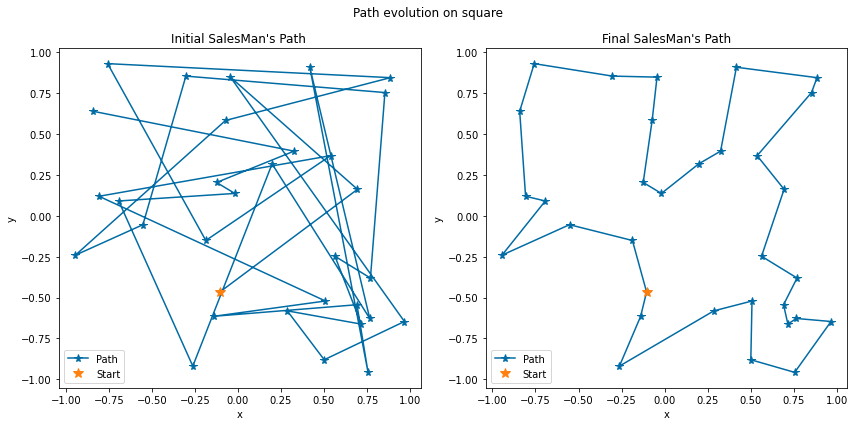

In [12]:
path('square')

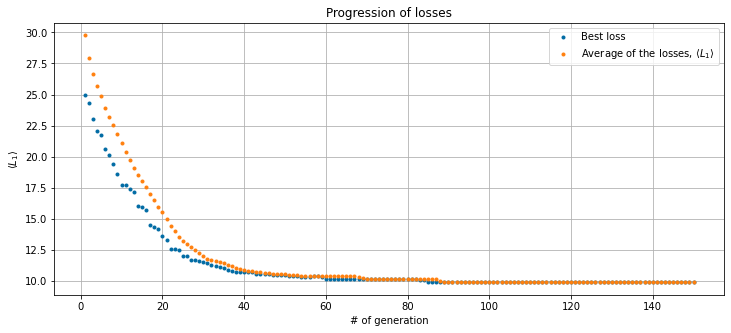

In [82]:
generation, fitness = (np.genfromtxt('./results/loss_square.dat', usecols=i, autostrip=True) for i in range(2))

plt.subplots(figsize=(12,5))
plt.plot(generation, fitness, 'o', markersize=3, label="Best loss")
generation, fitness = (np.genfromtxt('./results/loss_ave_square.dat', usecols=i, autostrip=True) for i in range(2))
plt.plot(generation, fitness, 'o', markersize=3, label=r"Average of the losses, $\langle L_1\rangle$")
plt.xlabel('# of generation')
plt.ylabel(r'$\langle L_1\rangle$')
plt.title('Progression of losses for path on a square')
plt.legend(loc=1)
plt.grid(True)
plt.show()

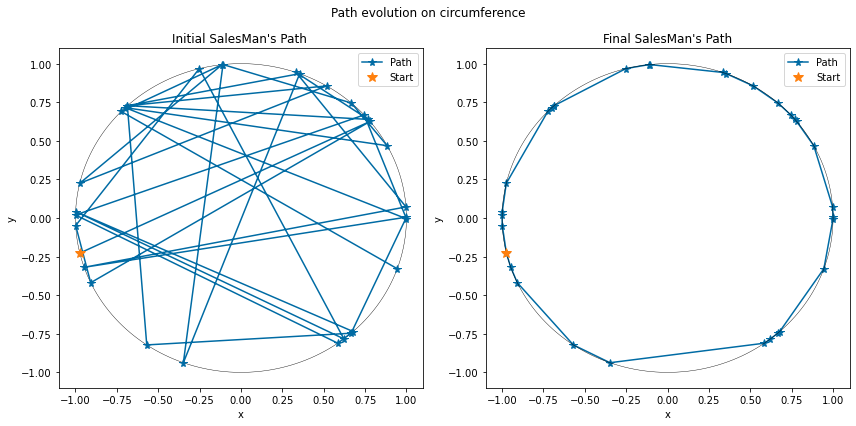

In [13]:
path('circumference')

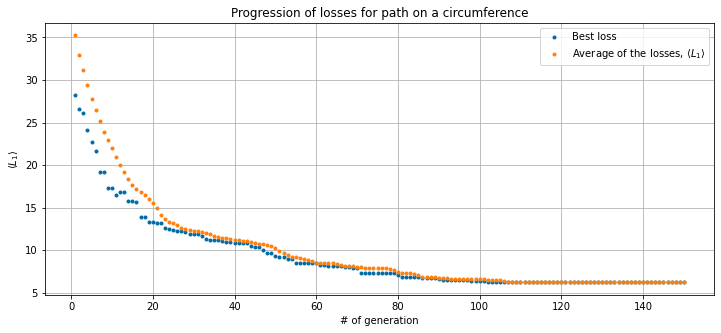

In [83]:
generation, fitness = (np.genfromtxt('./results/loss_circumference.dat', usecols=i, autostrip=True) for i in range(2)
plt.subplots(figsize=(12,5))
plt.plot(generation, fitness, 'o', markersize=3, label="Best loss")
generation, fitness = (np.genfromtxt('./results/loss_ave_circumference.dat', usecols=i, autostrip=True) for i in range(2))

plt.plot(generation, fitness, 'o', markersize=3, label=r"Average of the losses, $\langle L_1\rangle$")
plt.xlabel('# of generation')
plt.ylabel(r'$\langle L_1\rangle$')
plt.title('Progression of losses for path on a circumference')
plt.legend(loc=1)
plt.grid(True)
plt.show()